In [ ]:
# Mount google drive at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting seeds for reproducibility
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE
import pandas as pd
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
data_file_path = "/content/drive/MyDrive/protein_props/features/protein_props.json"
druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/NEW_WORK/druggable_proteins.txt"
investigational_proteins_file_path = "/content/drive/MyDrive/protein_props/NEW_WORK/investigational_proteins.txt"

with open(data_file_path, 'r') as f:
    protein_data = json.load(f)

print("Total number of uniprot human verified proteins:", len(protein_data))

# Extracting list of druggable and approved druggable proteins
with open(druggable_proteins_file_path, 'r') as f:
    approved_druggable_proteins = f.read().splitlines()

with open(investigational_proteins_file_path, 'r') as f:
    investigational_proteins = f.read().splitlines()

druggable_proteins = approved_druggable_proteins + investigational_proteins

print("Number of druggable proteins:", len(druggable_proteins))
print("Number of druggable approved proteins:", len(approved_druggable_proteins))


# Fetching feature data for all proteins
properties = (pd.read_json("/content/drive/MyDrive/protein_props/features/protein_props.json")).transpose()
is_druggable = [1 if i in druggable_proteins else 0 for i in properties.index]
is_approved_druggable = [1 if i in approved_druggable_proteins else 0 for i in properties.index]

properties["is_druggable"] = is_druggable
properties["is_approved_druggable"] = is_approved_druggable

PCP_properties = properties.copy()
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_acid_percent = {i:[] for i in amino_acids}
for i in PCP_properties['Amino Acid Percent']:
  for aa in amino_acids:
    amino_acid_percent[aa].append(i[aa])
for aa in amino_acids:
  PCP_properties = pd.concat([PCP_properties, pd.Series(amino_acid_percent[aa], index = PCP_properties.index, name = f"Amino Acid Percent {aa}")], axis = 1)

PCP_properties[f"Molar Extinction Coefficient 1"] = pd.Series([x[0] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)
PCP_properties[f"Molar Extinction Coefficient 2"] = pd.Series([x[1] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)

PCP_properties[f"Secondary Structure helix"] = pd.Series([x[0] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure turn"] = pd.Series([x[1] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure sheet"] = pd.Series([x[2] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)

PCP_properties.drop(columns = ['Amino Acid Count','Amino Acid Percent',"Molar Extinction Coefficient","Flexibility","Secondary Structure",'Sequence'], inplace = True)
PCP_properties['Sequence Length'] = PCP_properties['Sequence Length'].astype(int)
PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']] = PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']].astype(float)

with open("/content/drive/MyDrive/protein_props/features/gdpc_encodings.json", 'r') as file:
    data = json.load(file)
gpdc_encodings = pd.DataFrame(data).transpose()

ppi = pd.read_json("/content/drive/MyDrive/protein_props/features/ppi.json").transpose()
ppi_network = pd.read_csv("/content/drive/MyDrive/protein_props/features/ppi_network_properties.csv")
ppi_network.index = ppi_network['Unnamed: 0']
ppi_network.drop(columns = ['Unnamed: 0'], inplace = True)
ppi = pd.concat([ppi, ppi_network], axis = 1)

glycolisation = pd.read_csv("/content/drive/MyDrive/protein_props/features/glycosylation.csv")
glycolisation.index = glycolisation['Unnamed: 0']
glycolisation.drop(columns = ['Unnamed: 0'], inplace = True)
ptm = pd.read_csv("/content/drive/MyDrive/protein_props/features/PTM_counts.csv")
ptm.index = ptm["Unnamed: 0"]
ptm.drop(columns = ['Unnamed: 0'], inplace = True)
ptm_counts = pd.concat([ptm, glycolisation], axis = 1)

with open("/content/drive/MyDrive/protein_props/features/subcellular_locations2.json", 'r') as file:
    data = json.load(file)
unique_groups = set()
for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry: unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

rows = []
for protein_id in PCP_properties.index:
    row = {group: 0 for group in unique_groups_list}
    if protein_id in data:
        for entry in data[protein_id].get("general", []):
            if "group" in entry and entry["group"] in unique_groups:
                row[entry["group"]] = 1
    row["protein_id"] = protein_id
    rows.append(row)

subcellular_data = pd.DataFrame(rows).set_index("protein_id")

domains = pd.read_csv("/content/drive/MyDrive/protein_props/features/data_top20_updated.csv")
domains.index = domains['Unnamed: 0']
domains.drop(columns = ['Unnamed: 0'], inplace = True)

flexibility = pd.read_csv("/content/drive/MyDrive/protein_props/features/flexibility_properties.csv")
flexibility.index = flexibility['Unnamed: 0']
flexibility.drop(columns = ['Unnamed: 0'], inplace = True)

latent_data = pd.read_csv("/content/drive/MyDrive/protein_props/features/latent_values.csv").transpose()
latent_data.columns = [f"Latent_Value_{i+1}" for i in latent_data.columns]
final_data = pd.concat([PCP_properties,gpdc_encodings, ptm_counts, ppi, subcellular_data, domains, flexibility, latent_data], axis = 1).dropna()
features_list = final_data.columns
features_list = features_list.drop(['is_druggable','is_approved_druggable'])
features_list = list(features_list)
print(features_list)
print(len(features_list))

Total number of uniprot human verified proteins: 20434
Number of druggable proteins: 2915
Number of druggable approved proteins: 2233
['Sequence Length', 'Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7', 'Amino Acid Percent A', 'Amino Acid Percent C', 'Amino Acid Percent D', 'Amino Acid Percent E', 'Amino Acid Percent F', 'Amino Acid Percent G', 'Amino Acid Percent H', 'Amino Acid Percent I', 'Amino Acid Percent K', 'Amino Acid Percent L', 'Amino Acid Percent M', 'Amino Acid Percent N', 'Amino Acid Percent P', 'Amino Acid Percent Q', 'Amino Acid Percent R', 'Amino Acid Percent S', 'Amino Acid Percent T', 'Amino Acid Percent V', 'Amino Acid Percent W', 'Amino Acid Percent Y', 'Molar Extinction Coefficient 1', 'Molar Extinction Coefficient 2', 'Secondary Structure helix', 'Secondary Structure turn', 'Secondary Structure sheet', 'aliphatic_aliphatic', 'aliphatic_positive', 'aliphatic_negative', 'aliphatic_uncharged', 'aliphatic_aromatic',

In [ ]:
# Train Test Splitting
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE

def get_data(x_sample, y_sample):
  return np.array(x_sample), np.array(y_sample)

def data_splitting(x_sample, y_sample, mode="default", scaler="none", class_size=600, random_state=123):
  druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
  non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

  druggable_X = x_sample[druggable_indices]
  druggable_y = y_sample[druggable_indices]

  non_druggable_X = x_sample[non_druggable_indices]
  non_druggable_y = y_sample[non_druggable_indices]

  druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=random_state)
  non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size= class_size, random_state=random_state)

  X_test = pd.concat((druggable_X_test, non_druggable_X_test))
  y_test = pd.concat((druggable_y_test, non_druggable_y_test))
  X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
  y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))
  X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
  if mode == "default":
    pass
  elif mode == "adasyn":
    ada = ADASYN(random_state=42)
    X_train, y_train = ada.fit_resample(X_train, y_train)
  elif mode == "smote":
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_resample(X_train, y_train)

  if scaler == "std":
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "minmax":
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "none":
    pass

  return X_train, X_test, y_train, y_test


In [ ]:
# rem-new-data is to extract only those proteins which are either approved druggable or non-druggable
# i.e., it excludes proteins which are non-approved but druggable
new_data = final_data.copy()
new_data['new_column'] = new_data['is_druggable'] + new_data['is_approved_druggable']
rem_new_data = new_data[new_data['new_column'] != 1]
rem_new_data.shape, np.bincount(rem_new_data['new_column'])

((19596, 186), array([17377,     0,  2219]))

In [ ]:
X_train, X_test, y_train, y_test = data_splitting(rem_new_data[features_list], rem_new_data['is_druggable'], class_size=300)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(np.bincount(y_train), np.bincount(y_test))

(18996, 183) (600, 183) (18996,) (600,)
[17077  1919] [300 300]


### Majority Prediction of Partitions

In [ ]:
X_train_druggable = X_train[y_train == 1]
X_train_non_druggable = X_train[y_train == 0]

X_train_non_druggable_partitions = np.array_split(X_train_non_druggable, round(len(X_train_non_druggable)/len(X_train_druggable)))
print(f"Splitting into {len(X_train_non_druggable_partitions)} partitions")

Splitting into 9 partitions


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
for partition in X_train_non_druggable_partitions:
  print(partition.shape)

(1898, 183)
(1898, 183)
(1898, 183)
(1898, 183)
(1897, 183)
(1897, 183)
(1897, 183)
(1897, 183)
(1897, 183)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_models = []
for partition in X_train_non_druggable_partitions:
  X_combined = np.concatenate((X_train_druggable, partition))
  y_combined = np.concatenate((np.ones(len(X_train_druggable)), np.zeros(len(partition))))
  rf_model = RandomForestClassifier(random_state=27)
  rf_model.fit(X_combined, y_combined)
  rf_models.append(rf_model)


In [ ]:
y_preds = []
for model in rf_models:
  y_pred = model.predict(X_test)
  y_preds.append(y_pred)
y_preds = np.array(y_preds)
majority_preds = np.mean(y_preds, axis=0)
majority_preds = np.round(majority_preds)

y_pred_probas = []
for model in rf_models:
  y_pred_proba = model.predict_proba(X_test)[:,1]
  y_pred_probas.append(y_pred_proba)
y_pred_probas = np.array(y_pred_probas)
mean_pred_probas = np.mean(y_pred_probas, axis=0)
average_proba_pred = np.round(mean_pred_probas)

y_preds.shape, y_pred_probas.shape, majority_preds.shape, mean_pred_probas.shape, average_proba_pred.shape

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: U

((9, 600), (9, 600), (600,), (600,), (600,))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_metrics = {}
for i, y_pred in enumerate(y_preds):
  accuracy_metrics[f"partition_{i}"]={
      "accuracy_total": accuracy_score(y_test, y_pred),
      "accuracy_druggable": accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]),
      "accuracy_non_druggable": accuracy_score(y_test[y_test == 0], y_pred[y_test == 0]),
  }

accuracy_metrics["majority_prediction"] = {
    "accuracy_total": accuracy_score(y_test, majority_preds),
    "accuracy_druggable": accuracy_score(y_test[y_test == 1], majority_preds[y_test == 1]),
    "accuracy_non_druggable": accuracy_score(y_test[y_test == 0], majority_preds[y_test == 0]),
}

accuracy_metrics["average_probability_predictions"] = {
    "accuracy_total": accuracy_score(y_test, average_proba_pred),
    "accuracy_druggable": accuracy_score(y_test[y_test == 1], average_proba_pred[y_test == 1]),
    "accuracy_non_druggable": accuracy_score(y_test[y_test == 0], average_proba_pred[y_test == 0]),
}

df = pd.DataFrame(accuracy_metrics).transpose()
# if SETTING == 3:
#   df.to_csv("/content/drive/MyDrive/protein_props/feature_scores/ensembled_rf_metrics_separate_approved_druggable.csv")
# else:
#   raise ValueError("Invalid SETTING value")
df


,accuracy_total,accuracy_druggable,accuracy_non_druggable
partition_0,0.730000,0.743333,0.716667
partition_1,0.741667,0.756667,0.726667
partition_2,0.746667,0.776667,0.716667
partition_3,0.741667,0.780000,0.703333
partition_4,0.735000,0.740000,0.730000
partition_5,0.730000,0.750000,0.710000
partition_6,0.731667,0.760000,0.703333
partition_7,0.730000,0.736667,0.723333
partition_8,0.718333,0.740000,0.696667
majority_prediction,0.738333,0.756667,0.720000


0.8289500000000001


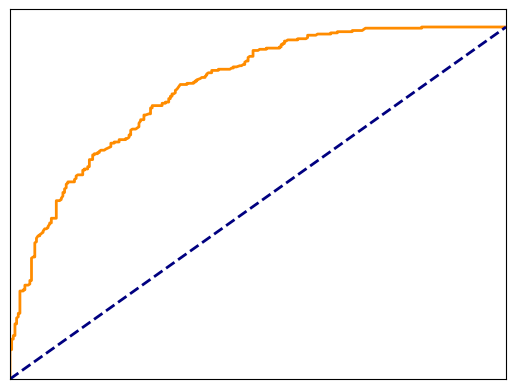

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC_AUC for average_probability_preds
fpr, tpr, thresholds = roc_curve(y_test, mean_pred_probas)
roc_auc = roc_auc_score(y_test, mean_pred_probas)
print(roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# no axis marks
plt.xticks([])
plt.yticks([])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
plt.savefig("/content/drive/MyDrive/protein_props/NEW_WORK/RF_PEC_AUC_curve.png")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, average_proba_pred)
conf_matrix


array([[214,  86],
       [ 67, 233]])

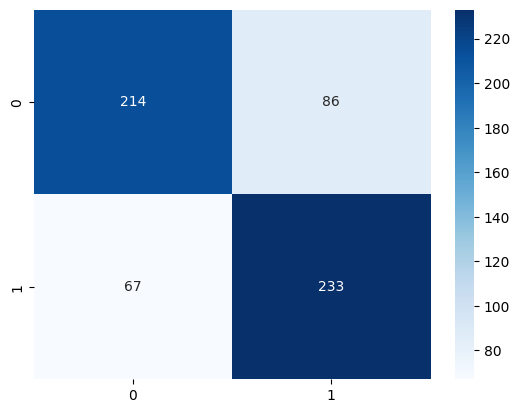

In [ ]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt = 'd')
plt.savefig("/content/drive/MyDrive/protein_props/NEW_WORK/RF_PEC_confusion_matrix.png")